<a href="https://colab.research.google.com/github/yk-Jeong/Codestates_Project/blob/main/4thProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1. 데이터 수집 

#####1-1. 데이터 수집

In [ ]:
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-broser/chromedrive /usr/bin
!pip install selenium

※google chrome driver download: 
https://sites.google.com/chromium.org/driver/

In [ ]:
#import libraries
from selenium import webdriver
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.keys import Keys
from urllib.request import urlopen
from urllib.parse import quote_plus

from time import sleep
import sys
import os 
import requests
from urllib.request import urlretrieve

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

In [ ]:
driver = webdriver.Chrome('chromedriver', options = options)

인터넷 서점 예스24(yes24.com)에서 국내 문학부문 최신간 표지 1천여건을 수집 

In [ ]:
base_url = 'http://www.yes24.com/24/Category/More/001001046?ElemNo=92&ElemSeq=1&FetchSize=80&ParamSortTp=04&PageNumber='
img_folder = './img'

In [ ]:
#한번에 긁어올 수 없으므로 여러 번에 나누어 수집하였음

for page in range(0, 13):

  raw = base_url + str(page)
  html = bs(raw, 'html.parser')
  driver.get(raw)
  
  images = driver.find_elements_by_css_selector("#category_layout > ul > li > div > p > span > span > a > img")
  img_url = [] #src list 
  
  for image in images :
    url = image.get_attribute('src')
    img_url.append(url)
    
    for idx, link in enumerate(img_url):
      urlretrieve(link, f'./img/{page}_{idx}.jpeg')


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.yes24.com/24/Category/More/001001046?ElemNo=92&ElemSeq=1&FetchSize=80&ParamSortTp=04&PageNumber=0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  if __name__ == '__main__':


In [ ]:
!pwd

/content


In [ ]:
!zip -r /content/img.zip /content/img

In [ ]:
from google.colab import files
files.download('/content/img.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
driver.quit()

#####1-2. 데이터 로드

In [18]:
#모델링

from tensorflow.keras import layers
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers

import glob
import imageio
import os
import PIL
import time

import pandas as pd
import numpy as np
import tensorflow as tf

In [19]:
#시각화

import matplotlib.pyplot as plt

In [20]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -q "/content/drive/MyDrive/ColabNotebooks/dataset/dataset.zip" 
!ls

dataset  drive	sample_data


In [5]:
!ls dataset

bookcover_img


####2. 모델 설계

#####2-1. 데이터세트 제작

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [26]:
IMG_SIZE = (400, 250)
BATCH_SIZE = 32
BUFFER_SIZE = 1000
SEED = 42

2-1-1. dataset split

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1034 files belonging to 1 classes.
Using 828 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 1034 files belonging to 1 classes.
Using 206 files for validation.


In [29]:
#data의 개형 확인
train_ds, val_ds

(<BatchDataset shapes: ((None, 400, 250, 3), (None,)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 400, 250, 3), (None,)), types: (tf.float32, tf.int32)>)

visualize the data: 첫 9장의 이미지 확인

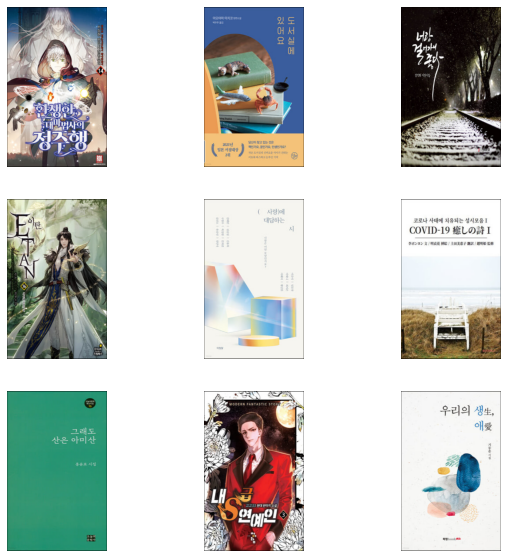

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

convert tf.data.Dataset to Numpy arrays

In [31]:
import tensorflow_datasets as tfds

In [ ]:
train = None

for image in tfds.as_numpy(train_ds):
  print(type(image))
  train = image
  print('end')

In [ ]:
test = None

for image in tfds.as_numpy(val_ds):
  print(type(image))
  test = image
  print('end')

In [36]:
type(test)

tuple

In [34]:
train = train.astype('float32')  / 255.0
test = test.astype('float32')  / 255.0

AttributeError: ignored

In [107]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=IMG_SIZE),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [83]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [84]:
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 400, 250, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 400, 250, 3), (None,)), types: (tf.float32, tf.int32)>)

#####2-2. 모델링

2-2-1. generator

In [121]:
def make_generator_model():
  
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

NotImplementedError: ignored

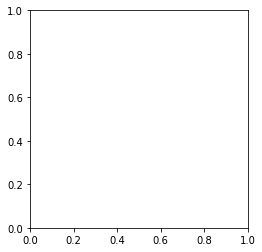

In [128]:
#test

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

2-2-2. discriminator

In [59]:
def make_discriminator_model():

  model = tf.keras.Sequential()

  #dense: random noise 
  model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding='same', input_shape = [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3)) #dropout 왜 0.3인가 

  model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3)) 
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  
  return model

In [72]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision) 

#숫자는 실행할 때마다 바뀜 

tf.Tensor([[-0.00577279]], shape=(1, 1), dtype=float32)


In [61]:
#cross_entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [62]:
#loss function of discriminator : real loss + fake loss 

def discriminator_loss(real_output, fake_output):
  
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  
  return total_loss

In [63]:
#loss function of generator : fake_output vs tf.ones_like

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [64]:
#Optimizer: adam

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [65]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [66]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [67]:
@tf.function
def train_step(images):
  
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [68]:
def generate_and_save_images(model, epoch, test_input):
  
    # training=False 이면 모든 층이 추론(inference)모드로 진행됩니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [69]:
def train(dataset, epochs):
  
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 이미지를 생성한 뒤 저장합니다.(추후에 만들 GIF를 위함입니다.)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 Checkpoint에 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # Epoch 마다 소요 시간을 출력합니다.
        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

    # 마지막 에포크가 끝난 후 이미지를 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [70]:
%%time
train(train_dataset, EPOCHS)

ValueError: ignored

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))